In [1]:
import sys
sys.path.insert(0,"../python/")
import modeling_utils as mu

In [2]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline

In [4]:
import sys
from datawand.parametrization import ParamHelper
ph = ParamHelper("../pipelines/EcmlTaxi.json",sys.argv)

Default parameters:
{u'data_folder': u'/home/fberes/DATA/taxi-challange/', u'gbt_use_exact_lat': False, u'lng_digits': 2, u'lat_digits': 3, u'is_test': False, u'part': u'_50000', u'gbt_use_exact_lng': False}
Custom parameters:
{}


In [5]:
data_folder = ph.get("data_folder")
part = ph.get("part")
lat_digits = ph.get("lat_digits")
lng_digits = ph.get("lng_digits")

Using default parameter: data_folder=/home/fberes/DATA/taxi-challange/
Using default parameter: part=_50000
Using default parameter: lat_digits=3
Using default parameter: lng_digits=2


# 1. Load data with generated features

In [6]:
taxi_trips = pd.read_csv("%s/gen_train%s_lng%i_lat%i.csv" % (data_folder, part, lng_digits, lat_digits))
taxi_trips = taxi_trips[['DESTINATION_LAT_FULL','DESTINATION_LNG_FULL','DESTINATION_LAT','DESTINATION_LNG']]

In [7]:
taxi_trips.columns

Index([u'DESTINATION_LAT_FULL', u'DESTINATION_LNG_FULL', u'DESTINATION_LAT',
       u'DESTINATION_LNG'],
      dtype='object')

In [8]:
taxi_trips.head()

,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL,DESTINATION_LAT,DESTINATION_LNG
0,41.154489,-8.630838,41.154,-8.63
1,41.170671,-8.665740,41.171,-8.67
2,41.140530,-8.615970,41.141,-8.62
3,41.142915,-8.607996,41.143,-8.61
4,41.178087,-8.687268,41.178,-8.69


In [9]:
lat_splits = sorted(taxi_trips["DESTINATION_LAT"].unique())
print 'Unique latitude splits: %i' % len(lat_splits)

Unique latitude splits: 405


In [10]:
lng_splits = sorted(taxi_trips["DESTINATION_LNG"].unique())
print 'Unique longitude splits: %i' % len(lng_splits)

Unique longitude splits: 77


# 2. Drop invalid data

In [11]:
print len(taxi_trips)
taxi_trips = taxi_trips[np.isfinite(taxi_trips["DESTINATION_LAT_FULL"])]
print len(taxi_trips)
taxi_trips = taxi_trips[np.isfinite(taxi_trips["DESTINATION_LNG_FULL"])]
print len(taxi_trips)

50000
49800
49800


# 3. Generate location cell keys

## a.) For the traing data

In [12]:
def generate_bins(df,col,digits,loc_bounds=None):
    eps = 0.0001
    prec = np.power(10.0,-1.0 * digits)
    print prec
    if loc_bounds == None:
        loc_min, loc_max = df[col].min(), df[col].max()
    else:
        loc_min, loc_max = loc_bounds
    #loc_splits = np.arange(loc_min-prec,loc_max+prec,prec)
    loc_splits = np.arange(loc_min-prec,loc_max+2*prec,prec)
    print loc_min, loc_max, len(loc_splits)
    return pd.cut(df[col],loc_splits,include_lowest=True,labels=range(len(loc_splits)-1)), (loc_min, loc_max)

def generate_loc_key(df,lat_col,lng_col,lat_bounds=None,lng_bounds=None,drop_tmp_keys=True):
    df["LAT_KEY"], lat_bounds = generate_bins(df,lat_col,digits=lat_digits,loc_bounds=lat_bounds)
    df["LNG_KEY"], lng_bounds = generate_bins(df,lng_col,digits=lng_digits,loc_bounds=lng_bounds)
    df["LOC_KEY"] = df.apply(lambda x: "%s_%s" % (str(x["LAT_KEY"]),str(x["LNG_KEY"])), axis=1)
    if drop_tmp_keys:
        df = df.drop(["LAT_KEY","LNG_KEY"],axis=1)
    print len(df["LOC_KEY"].unique())
    return df, lat_bounds, lng_bounds

In [13]:
taxi_trips, LAT_BOUNDS, LNG_BOUNDS = generate_loc_key(taxi_trips,lat_col="DESTINATION_LAT_FULL",lng_col="DESTINATION_LNG_FULL")

0.001
38.71548 41.954076 3242
0.01
-9.136584 -6.958692 221
2249


In [14]:
taxi_trips.head(2)

,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL,DESTINATION_LAT,DESTINATION_LNG,LOC_KEY
0,41.154489,-8.630838,41.154,-8.63,2440_51
1,41.170671,-8.665740,41.171,-8.67,2456_48


## b.) Apply these cells for GBT model predictions

In [15]:
gbt_train_prediction = pd.read_csv("%s/gbt_model_pred_train%s_lng%i_lat%i.csv"  % (data_folder, part, lng_digits, lat_digits))
gbt_train_prediction = gbt_train_prediction.drop(["DESTINATION_LAT","DESTINATION_LNG"],axis=1)
print len(gbt_train_prediction)

50000


In [16]:
gbt_test_prediction = pd.read_csv("%s/gbt_model_pred_test%s_lng%i_lat%i.csv"  % (data_folder, part, lng_digits, lat_digits))
gbt_test_prediction = gbt_test_prediction.drop(["DESTINATION_LAT","DESTINATION_LNG"],axis=1)
print len(gbt_test_prediction)

320


In [17]:
gbt_train_prediction.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL,DEPARTURE_LAT_FULL,DEPARTURE_LNG_FULL,...,DAY_OF_WEEK,TIME_OF_DAY,CALL_TYPE_onehot_dispatch,CALL_TYPE_onehot_driver,CALL_TYPE_onehot_other,PRED_LAT,PRED_LNG,LABEL_LAT,LABEL_LNG,HAVERSINE
0,other,22912.505749,30.084759,20000589,normal,False,41.154489,-8.630838,41.141412,-8.618643,...,0,0,0.0,0.0,1.0,41.156095,-8.626126,41.154489,-8.630838,0.432992
1,driver,22912.505749,7.000000,20000596,normal,False,41.170671,-8.665740,41.159826,-8.639847,...,0,0,0.0,1.0,0.0,41.167953,-8.669209,41.170671,-8.665740,0.419065
2,other,22912.505749,30.084759,20000320,normal,False,41.140530,-8.615970,41.140359,-8.612964,...,0,0,0.0,0.0,1.0,41.155590,-8.646429,41.140530,-8.615970,3.050962
3,other,22912.505749,30.084759,20000520,normal,False,41.142915,-8.607996,41.151951,-8.574678,...,0,0,0.0,0.0,1.0,41.144324,-8.610278,41.142915,-8.607996,0.247135
4,other,22912.505749,30.084759,20000337,normal,False,41.178087,-8.687268,41.180490,-8.645994,...,0,0,0.0,0.0,1.0,41.173450,-8.685458,41.178087,-8.687268,0.537421


In [18]:
gbt_train_prediction, _, _ = generate_loc_key(gbt_train_prediction,lat_col="LABEL_LAT",lng_col="LABEL_LNG",lat_bounds=LAT_BOUNDS,lng_bounds=LNG_BOUNDS)

0.001
38.71548 41.954076 3242
0.01
-9.136584 -6.958692 221
2249


In [19]:
gbt_test_prediction, _, _ = generate_loc_key(gbt_test_prediction,lat_col="LABEL_LAT",lng_col="LABEL_LNG",lat_bounds=LAT_BOUNDS,lng_bounds=LNG_BOUNDS)

0.001
38.71548 41.954076 3242
0.01
-9.136584 -6.958692 221
199


In [20]:
len(set(gbt_train_prediction["LOC_KEY"]).intersection(set(gbt_test_prediction["LOC_KEY"])))

193

# 4. Define POI based on GPS locations

In [21]:
from haversine import haversine

#### Round locations for  ~10 meter precision to define spots

In [22]:
haversine((-8.618643, 41.1414),(-8.618643, 41.1415))

0.010993927713293054

In [23]:
PRECISION = 4
taxi_trips["DESTINATION_LAT"] = taxi_trips["DESTINATION_LAT_FULL"].apply(lambda x: round(x,PRECISION))
taxi_trips["DESTINATION_LNG"] = taxi_trips["DESTINATION_LNG_FULL"].apply(lambda x: round(x,PRECISION))

#### Mean distance after decreasing the accuracy of GPS locations: ~3 meter

In [24]:
mean_haversine, _ = mu.compute_mean_haversine(taxi_trips,("DESTINATION_LAT","DESTINATION_LNG"),("DESTINATION_LAT_FULL","DESTINATION_LNG_FULL"))
print mean_haversine

0.00373943891912


In [25]:
taxi_trips["POI"] = taxi_trips.apply(lambda x: (x["DESTINATION_LAT"],x["DESTINATION_LNG"]),axis=1)

In [26]:
taxi_trips.head(2)

,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL,DESTINATION_LAT,DESTINATION_LNG,LOC_KEY,HAVERSINE,POI
0,41.154489,-8.630838,41.1545,-8.6308,2440_51,0.003408,"(41.1545, -8.6308)"
1,41.170671,-8.665740,41.1707,-8.6657,2456_48,0.004648,"(41.1707, -8.6657)"


### Location popularity histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cda6dcf50>]], dtype=object)

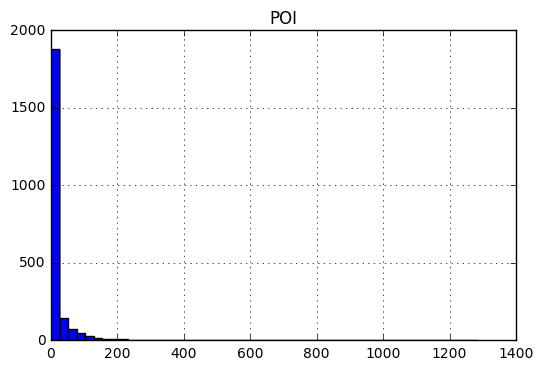

In [27]:
taxi_trips[["LOC_KEY","POI"]].groupby("LOC_KEY").count().hist(bins=50)

# 5. Specifying destination predictions

## a.) Predict the mean of spots within a cell

In [28]:
cell_means = taxi_trips[["LOC_KEY","DESTINATION_LAT","DESTINATION_LNG"]].groupby("LOC_KEY").mean()
cell_means = pd.DataFrame(cell_means).reset_index()

In [29]:
cell_means.head()

,LOC_KEY,DESTINATION_LAT,DESTINATION_LNG
0,0_0,38.71550,-9.13660
1,1032_29,39.74720,-8.85570
2,1436_29,40.15110,-8.84870
3,1493_72,40.20795,-8.42455
4,1502_71,40.21650,-8.43550


In [30]:
def set_mean_destination(df,detailed_locs):
    joined = df.merge(detailed_locs,on="LOC_KEY",how='left')
    joined["MEAN_PRED_LAT"] = joined.apply(lambda x: x["PRED_LAT"] if x["DESTINATION_LAT"] == np.nan else x["DESTINATION_LAT"],axis=1)
    joined["MEAN_PRED_LNG"] = joined.apply(lambda x: x["PRED_LNG"] if x["DESTINATION_LNG"] == np.nan else x["DESTINATION_LNG"],axis=1)
    return joined

In [31]:
gbt_train_prediction = set_mean_destination(gbt_train_prediction,cell_means)

In [32]:
gbt_test_prediction = set_mean_destination(gbt_test_prediction,cell_means)

#### There are 6 routes that are not covered due to the fact that I only used a small fraction of the training data

In [33]:
gbt_test_prediction[gbt_test_prediction["MEAN_PRED_LNG"].isnull()]

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,DAY_TYPE,MISSING_DATA,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL,DEPARTURE_LAT_FULL,DEPARTURE_LNG_FULL,...,PRED_LAT,PRED_LNG,LABEL_LAT,LABEL_LNG,HAVERSINE,LOC_KEY,DESTINATION_LAT,DESTINATION_LNG,MEAN_PRED_LAT,MEAN_PRED_LNG
70,C,38074.083333,29.99187,20000010,A,False,41.556375,-8.376903,41.179689,-8.624304,...,41.517433,-8.433817,41.556375,-8.376903,6.417958,2841_76,NaN,NaN,NaN,NaN
71,C,38074.083333,29.99187,20000004,A,False,41.330565,-8.729766,41.163660,-8.663877,...,41.291100,-8.715082,41.330565,-8.729766,4.556517,2616_41,NaN,NaN,NaN,NaN
111,A,2002.000000,29.99187,20000230,A,False,41.196969,-8.506980,41.181768,-8.601291,...,41.194662,-8.522353,41.196969,-8.506980,1.311599,2482_63,NaN,NaN,NaN,NaN
125,C,38074.083333,29.99187,20000384,A,False,41.185035,-7.551891,41.168538,-8.546940,...,41.179523,-7.567966,41.185035,-7.551891,1.478303,2470_159,NaN,NaN,NaN,NaN
230,B,38074.083333,57.00000,20000554,A,False,41.120460,-8.585766,41.145597,-8.610777,...,41.120794,-8.591915,41.120460,-8.585766,0.516423,2405_56,NaN,NaN,NaN,NaN
253,C,38074.083333,29.99187,20000192,A,False,41.091489,-8.650017,41.145876,-8.613540,...,41.101321,-8.641256,41.091489,-8.650017,1.316855,2377_49,NaN,NaN,NaN,NaN


### Performance results of the mean predictor model

In [34]:
mean_pred_train_haversine, _ = mu.compute_mean_haversine(gbt_train_prediction,("MEAN_PRED_LAT","MEAN_PRED_LNG"),("LABEL_LAT","LABEL_LNG"))
mean_pred_test_haversine, _ = mu.compute_mean_haversine(gbt_test_prediction,("MEAN_PRED_LAT","MEAN_PRED_LNG"),("LABEL_LAT","LABEL_LNG"))
print "Test: %f, Train: %f (Haversine)" % (mean_pred_test_haversine,mean_pred_train_haversine)

Test: 0.172401, Train: 0.142799 (Haversine)


In [35]:
mean_pred_test_haversine, _ = mu.compute_mean_haversine(gbt_test_prediction,("MEAN_PRED_LAT","MEAN_PRED_LNG"),("LABEL_LAT","LABEL_LNG"))
print mean_pred_test_haversine

0.172401286192


In [36]:
print len(gbt_train_prediction), len(gbt_test_prediction)

50000 320


## b.) Combine locations using k-closest point

#### Trip length based features had to be excluded: because in test the trip length was smaller

In [37]:
#feat_order = list(gbt_importances["name"])
feat_order = []
feat_order += ["DEPARTURE_LAT","TRIP_LAT_MEAN","TRIP_LAT_MIN","TRIP_LAT_MAX","TRIP_LAT_MEDIAN"]
feat_order += ["DEPARTURE_LNG","TRIP_LNG_MEAN","TRIP_LNG_MIN","TRIP_LNG_MAX","TRIP_LNG_MEDIAN"]
feat_order += ['DESTINATION_LAT_FULL', 'DESTINATION_LNG_FULL']
print feat_order

['DEPARTURE_LAT', 'TRIP_LAT_MEAN', 'TRIP_LAT_MIN', 'TRIP_LAT_MAX', 'TRIP_LAT_MEDIAN', 'DEPARTURE_LNG', 'TRIP_LNG_MEAN', 'TRIP_LNG_MIN', 'TRIP_LNG_MAX', 'TRIP_LNG_MEDIAN', 'DESTINATION_LAT_FULL', 'DESTINATION_LNG_FULL']


In [38]:
%%time
knn_models, cell_locations = mu.init_knn_models(gbt_train_prediction,feat_order,k=2)

Number of unique cell keys: 2249
CPU times: user 15.7 s, sys: 34 ms, total: 15.7 s
Wall time: 15.7 s


In [39]:
%%time
mu.predict_with_knn(gbt_test_prediction,knn_models,cell_locations,feat_order)

CPU times: user 882 ms, sys: 2 ms, total: 884 ms
Wall time: 881 ms


%%time
predict_with_knn(gbt_train_prediction,knn_models,cell_locations,feat_order)

In [40]:
gbt_test_prediction[feat_order].head()

,DEPARTURE_LAT,TRIP_LAT_MEAN,TRIP_LAT_MIN,TRIP_LAT_MAX,TRIP_LAT_MEDIAN,DEPARTURE_LNG,TRIP_LNG_MEAN,TRIP_LNG_MIN,TRIP_LNG_MAX,TRIP_LNG_MEDIAN,DESTINATION_LAT_FULL,DESTINATION_LNG_FULL
0,41.149,41.148444,41.147000,41.149000,41.149000,-8.59,-8.590000,-8.590000,-8.590000,-8.590000,41.146623,-8.584884
1,41.146,41.154658,41.146000,41.163000,41.154000,-8.61,-8.604474,-8.610000,-8.600000,-8.600000,41.163597,-8.601894
2,41.149,41.154605,41.145000,41.167000,41.154000,-8.59,-8.582105,-8.590000,-8.580000,-8.580000,41.167719,-8.574903
3,41.141,41.141000,41.141000,41.141000,41.141000,-8.61,-8.618333,-8.620000,-8.610000,-8.620000,41.140980,-8.614638
4,41.148,41.160227,41.152359,41.168429,41.160223,-8.62,-8.614016,-8.626795,-8.603013,-8.613365,41.148036,-8.619894


### Performance results of the k-NN based model

In [41]:
knn_pred_test_haversine, _ = mu.compute_mean_haversine(gbt_test_prediction,("KNN_PRED_LAT","KNN_PRED_LNG"),("LABEL_LAT","LABEL_LNG"))
print knn_pred_test_haversine

0.173984321749


In [42]:
len(gbt_test_prediction)

320

In [43]:
len(gbt_test_prediction[(gbt_test_prediction["MEAN_PRED_LAT"] != gbt_test_prediction["KNN_PRED_LAT"]) | (gbt_test_prediction["MEAN_PRED_LNG"] != gbt_test_prediction["KNN_PRED_LNG"])])

310

# Visualization of the predictions

In [48]:
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()

def visualize_predition(df, pred_prefix, mean_haversine, show_mean=False):
    lat0 = df["LABEL_LAT"]
    lat1 = df["%s_PRED_LAT" % pred_prefix]
    lng0 = df["LABEL_LNG"]
    lng1 = df["%s_PRED_LNG" % pred_prefix]
    lat2 = df["MEAN_PRED_LAT"]
    lng2 = df["MEAN_PRED_LNG"]
    # init plot
    p = figure(title = "Predicted Destinations with %s. Mean Haversine distance: %f" % (pred_prefix,mean_haversine), width=900, height=600)
    p.xaxis.axis_label = 'LNG'
    p.yaxis.axis_label = 'LAT'
    # errors
    p.segment(x0=lng0, y0=lat0, x1=lng1, y1=lat1, color="black", line_width=1)
    # locations
    if show_mean:
        p.circle(lng2, lat2, color='green', fill_alpha=0.2, size=10)
    p.circle(lng1, lat1, color='red', fill_alpha=0.2, size=10)
    p.circle(lng0, lat0, color='blue', fill_alpha=0.2, size=10)
    #output
    output_file("%s_destination_prediction_lng%i_lat%i.html" % (pred_prefix, lng_digits, lat_digits), title="Predicted Destinations")
    show(p, notebook_handle=True)

Loading BokehJS ...

### Prediction results of the mean predictor

In [49]:
visualize_predition(gbt_test_prediction,"MEAN",mean_pred_test_haversine)

INFO:bokeh.core.state:Session output file 'MEAN_destination_prediction_lng2_lat3.html' already exists, will be overwritten.


### Prediction results of the k-NN predictor

In [50]:
visualize_predition(gbt_test_prediction,"KNN",knn_pred_test_haversine,show_mean=False)

INFO:bokeh.core.state:Session output file 'KNN_destination_prediction_lng2_lat3.html' already exists, will be overwritten.
